## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1.1 Display all column in dataframe

In [2]:
# Set display limit columns in the dataframe to 40. To visualize all columns instead of "..." in between them
pd.set_option('display.max_columns', 40)

# set display limit columns in the dataframe to 100. To visualize all rows instead of "..." in between
pd.set_option('display.max_rows', 200)

## 2. Prepare database and Preprocessing

### 2.1 Load dataframe

In [3]:
# Load the dataset
file_path = '../raw_data/df_all_races.csv'

# file_path = '/home/mgasilva/code/diegonbotelho/f1-tire-prediction/raw_data/df_all_races.csv'
all_races_df = pd.read_csv(file_path)

In [4]:
all_races_df = all_races_df[all_races_df['TrackStatus'] ==1]

In [5]:
all_races_df.shape

(59920, 41)

### 2.2 Preprocess Dataframe

In [6]:
all_races_df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Event_Year,GrandPrix,Delta_Lap
0,0 days 01:04:15.340000,VER,1,100.236,1.0,1.0,NaN,NaN,NaN,42.325,24.389,NaN,3831.046,3855.427,230.0,254.0,274.0,250.0,False,SOFT,...,False,Red Bull Racing,0 days 01:02:34.872000,2022-03-20 15:03:34.889,1,2.0,False,NaN,False,False,23.9,25.0,1010.2,False,29.1,20,0.5,2022,Bahrain,0.000
1,0 days 01:05:53.220000,VER,1,97.880,2.0,1.0,NaN,NaN,31.285,42.269,24.326,3886.662,3928.931,3953.257,NaN,252.0,276.0,296.0,True,SOFT,...,False,Red Bull Racing,0 days 01:04:15.340000,2022-03-20 15:05:15.357,1,2.0,False,NaN,False,True,23.8,26.0,1010.4,False,29.0,357,0.5,2022,Bahrain,-2.356
2,0 days 01:07:31.577000,VER,1,98.357,3.0,1.0,NaN,NaN,31.499,42.474,24.384,3984.756,4027.230,4051.614,229.0,254.0,276.0,294.0,False,SOFT,...,False,Red Bull Racing,0 days 01:05:53.220000,2022-03-20 15:06:53.237,1,2.0,False,NaN,False,True,23.8,27.0,1010.4,False,29.0,12,0.5,2022,Bahrain,0.477
3,0 days 01:09:10.143000,VER,1,98.566,4.0,1.0,NaN,NaN,31.342,42.674,24.550,4082.956,4125.630,4150.180,231.0,250.0,276.0,297.0,False,SOFT,...,False,Red Bull Racing,0 days 01:07:31.577000,2022-03-20 15:08:31.594,1,2.0,False,NaN,False,True,23.8,29.0,1010.4,False,28.7,12,0.4,2022,Bahrain,0.209
4,0 days 01:10:49.020000,VER,1,98.877,5.0,1.0,NaN,NaN,31.498,42.854,24.525,4181.678,4224.532,4249.057,229.0,256.0,276.0,293.0,False,SOFT,...,False,Red Bull Racing,0 days 01:09:10.143000,2022-03-20 15:10:10.160,1,2.0,False,NaN,False,True,23.8,33.0,1010.4,False,28.5,316,0.4,2022,Bahrain,0.311


In [7]:
# check each column type
all_races_df.dtypes

Time                   object
Driver                 object
DriverNumber            int64
LapTime               float64
LapNumber             float64
Stint                 float64
PitOutTime             object
PitInTime              object
Sector1Time           float64
Sector2Time           float64
Sector3Time           float64
Sector1SessionTime    float64
Sector2SessionTime    float64
Sector3SessionTime    float64
SpeedI1               float64
SpeedI2               float64
SpeedFL               float64
SpeedST               float64
IsPersonalBest         object
Compound               object
TyreLife              float64
FreshTyre                bool
Team                   object
LapStartTime           object
LapStartDate           object
TrackStatus             int64
Position              float64
Deleted                  bool
DeletedReason          object
FastF1Generated          bool
IsAccurate               bool
AirTemp               float64
Humidity              float64
Pressure  

In [8]:
# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (59920, 41)


In [9]:
first_and_last_laps_in_stint_indexes = all_races_df[(all_races_df.PitInTime.notna()) | 
(all_races_df.PitOutTime.notna()) | 
(all_races_df.LapNumber == 1.0)].index

all_races_df.drop(first_and_last_laps_in_stint_indexes, inplace=True)

In [10]:
# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (56048, 41)


In [11]:
# Exclusion of features that are not necessary
drop_columns = [
    'Time',
    'DriverNumber',
    'PitOutTime',
    'PitInTime',
    'Sector1SessionTime',
    'Sector2SessionTime',
    'Sector3SessionTime',
    'SpeedI1',
    'SpeedI2',
    'SpeedFL',
    'SpeedST',
    'IsPersonalBest',
    'FreshTyre',
    'Team',
    'LapStartTime',
    'LapStartDate',
    'TrackStatus',
    'Deleted',
    'DeletedReason',
    'FastF1Generated',
    'IsAccurate',
    'WindDirection',
    'WindSpeed',
    'Delta_Lap'
]

new_df = all_races_df.drop(columns=drop_columns, inplace=True)

In [12]:
# Missing Data Analysis
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Driver          0
LapTime        94
LapNumber       0
Stint           0
Sector1Time    52
Sector2Time    45
Sector3Time    43
Compound        0
TyreLife        0
Position       41
AirTemp         0
Humidity        0
Pressure        0
Rainfall        0
TrackTemp       0
Event_Year      0
GrandPrix       0
dtype: int64


In [13]:
# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (56048, 17)


In [14]:
# drop nan in position column
all_races_df.dropna(subset=['Position'], inplace=True)

# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (56007, 17)


In [15]:
# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (56007, 17)


In [16]:
# Verify duplicates
print("Number of duplicates:")
print(all_races_df.duplicated().sum())

Number of duplicates:
0


In [17]:
# checking once again if missing values in position column no longer exist
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Driver          0
LapTime        53
LapNumber       0
Stint           0
Sector1Time    11
Sector2Time     4
Sector3Time     2
Compound        0
TyreLife        0
Position        0
AirTemp         0
Humidity        0
Pressure        0
Rainfall        0
TrackTemp       0
Event_Year      0
GrandPrix       0
dtype: int64


In [18]:
# # Checking different values in each column
# for col in all_races:
#     print(all_races[col].unique())

In [19]:
# # ceeck different unique values in compound column
# print(all_races['Compound'].unique())

In [20]:
# Replace in the Rainfall column, False -> 0 and Ture -> 1 
all_races_df.replace({'Rainfall': {False: 0, True: 1}}, inplace=True)

/tmp/ipykernel_133577/714375794.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_races_df.replace({'Rainfall': {False: 0, True: 1}}, inplace=True)


In [21]:
# Identify categorical and numerical columns
numerical_columns = all_races_df.select_dtypes(include=[np.number]).columns
categorical_columns = all_races_df.select_dtypes(include=object).columns

print(f'Numerical columns: \n {numerical_columns}')
print(f'Categorical columns: \n {categorical_columns}')

Numerical columns: 
 Index(['LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'TyreLife', 'Position', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'Event_Year'],
      dtype='object')
Categorical columns: 
 Index(['Driver', 'Compound', 'GrandPrix'], dtype='object')


### 2.3 Pre-visualization

In [22]:
# define a function to draw a histplot and boxplot graph
def graph(feature):
    # Set up the ppfigure and subplots
    plt.figure(figsize=(16, 6))  # Set the figure size (width, height)

    # Subplot 1: Histogram
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    sns.histplot(all_races_df[feature], color='skyblue')  # Create a histogram with KDE
    plt.title(f'Histogram of {feature}', fontsize=16)  # Add a title
    plt.xlabel(f'{feature}', fontsize=14)  # Label the x-axis
    plt.ylabel('Frequency', fontsize=14)  # Label the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

    # Subplot 2: Boxplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    sns.boxplot(x=all_races_df[feature], color='lightgreen')  # Create a boxplot
    plt.title(f'Boxplot of {feature}', fontsize=16)  # Add a title
    plt.xlabel(f'{feature}', fontsize=14)  # Label the x-axis
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability

    # Adjust layout and display the plot
    plt.tight_layout()  # Automatically adjust subplot spacing
    plt.show()

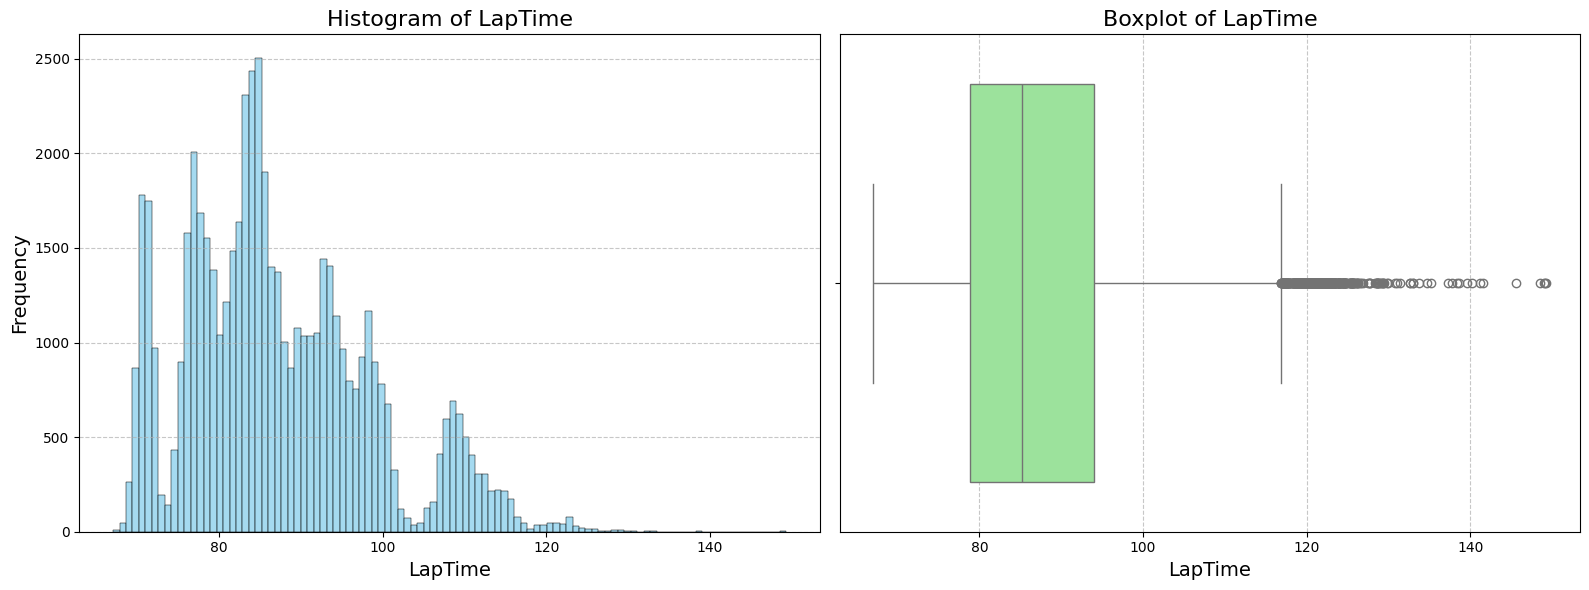

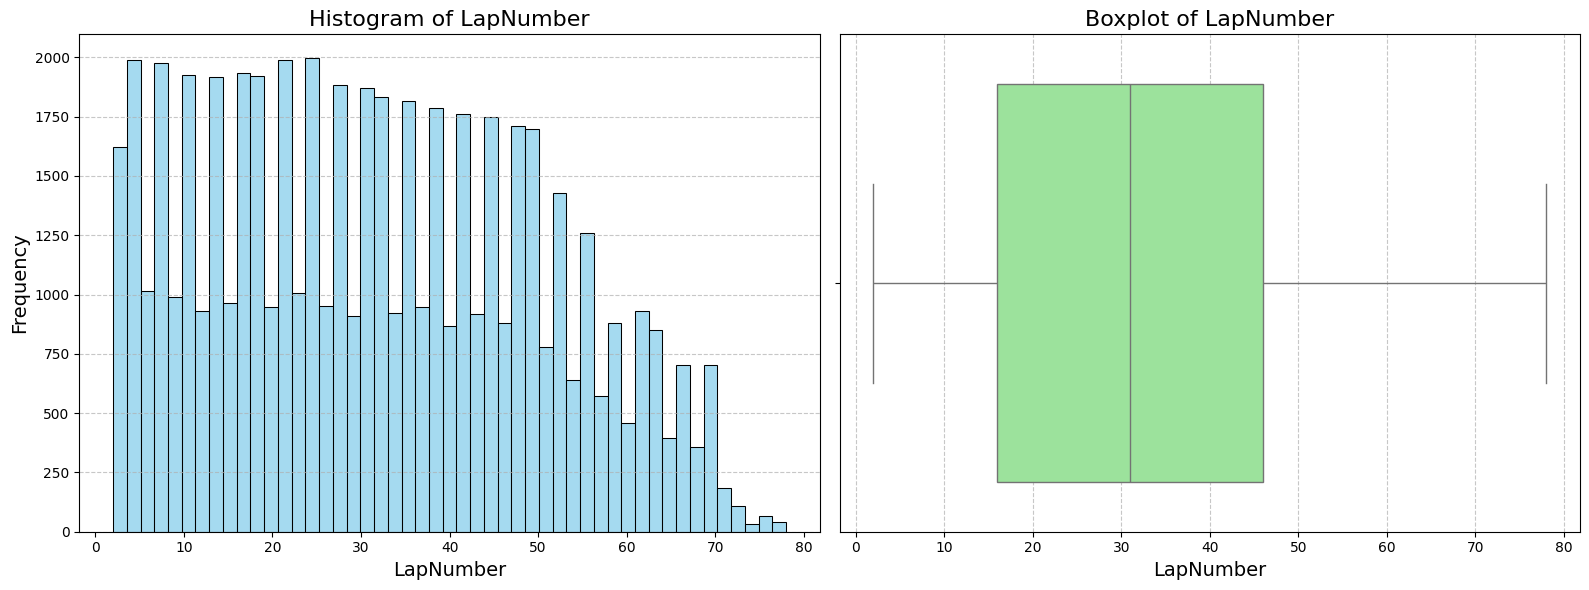

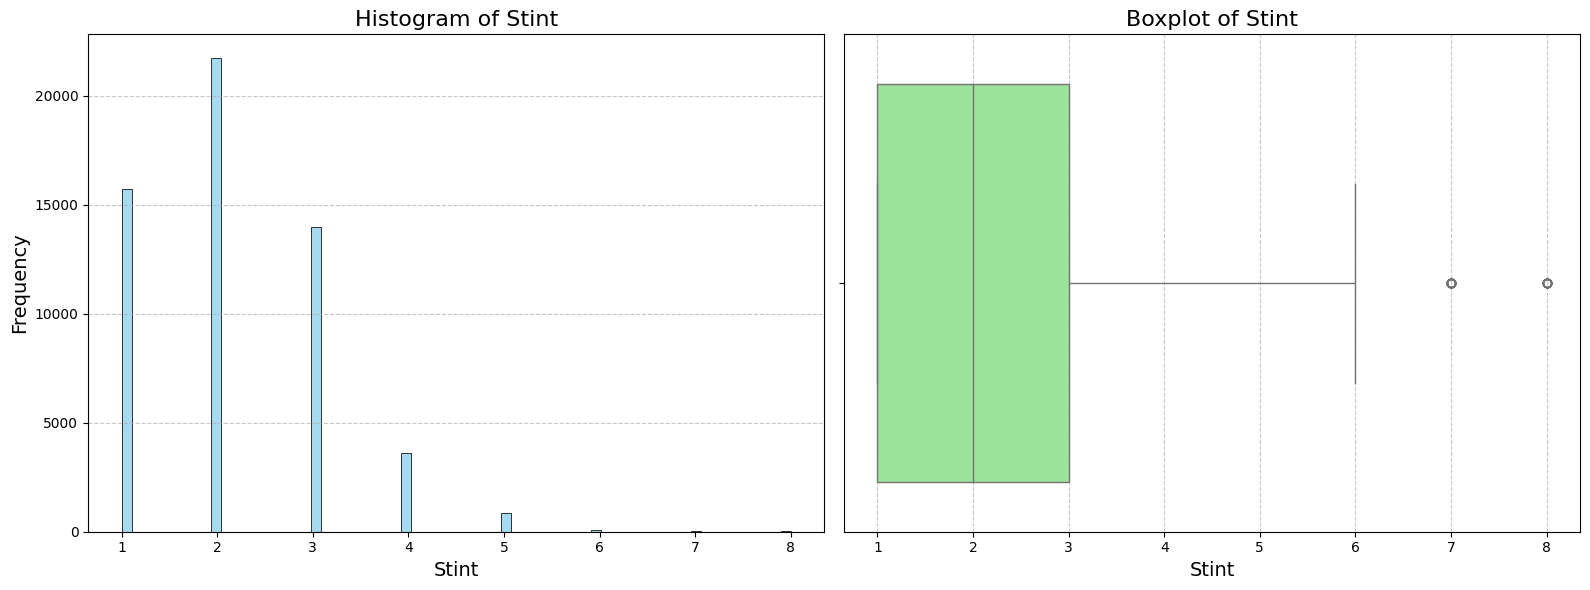

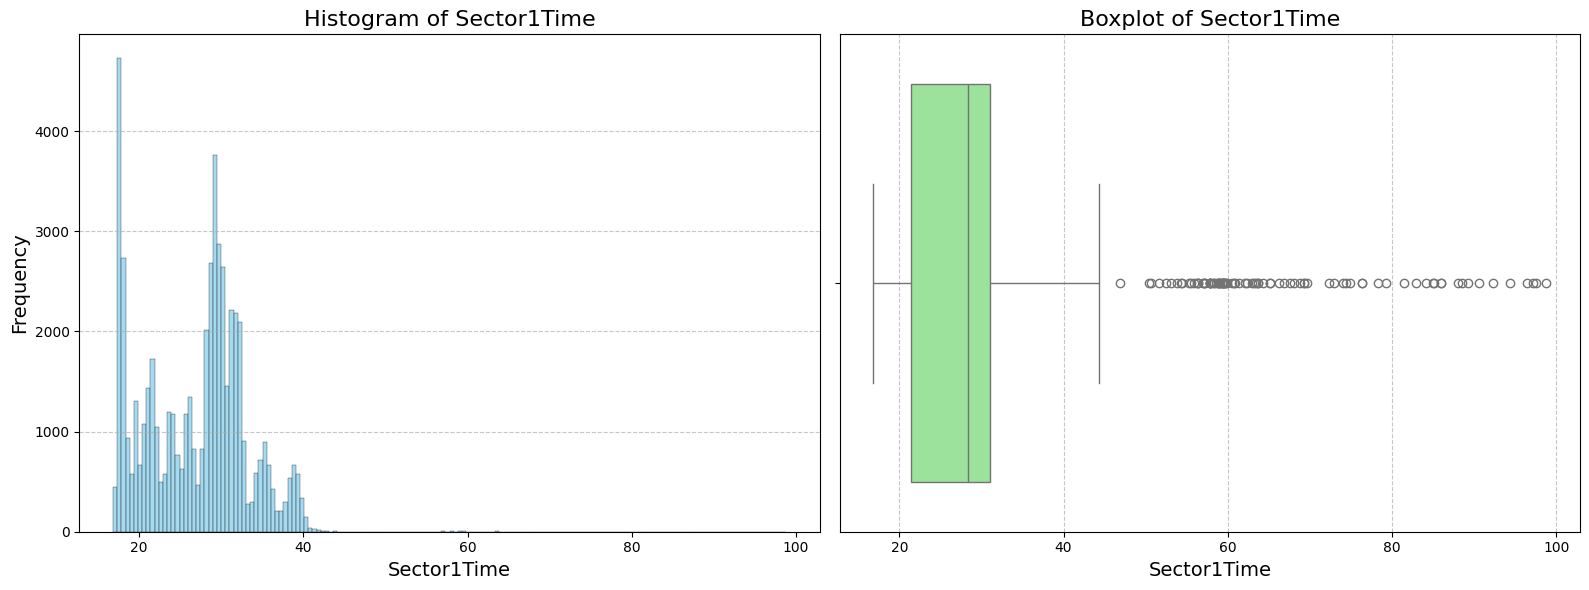

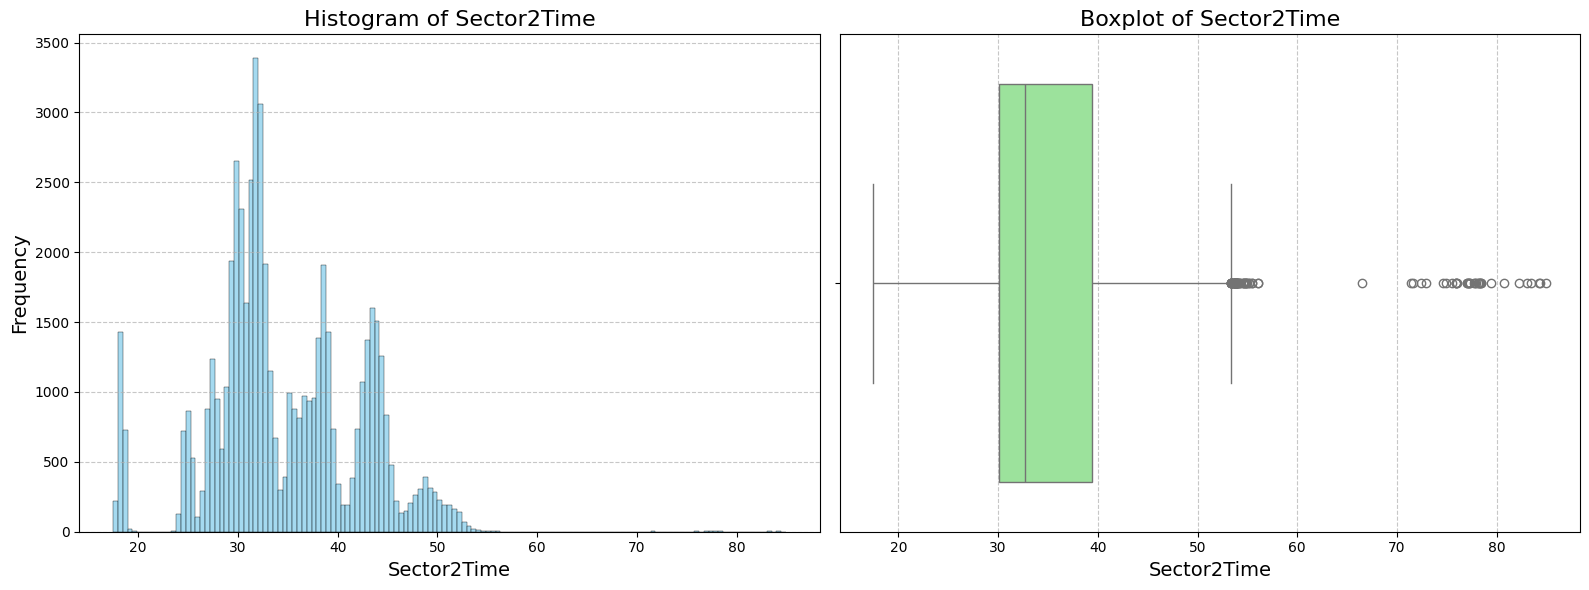

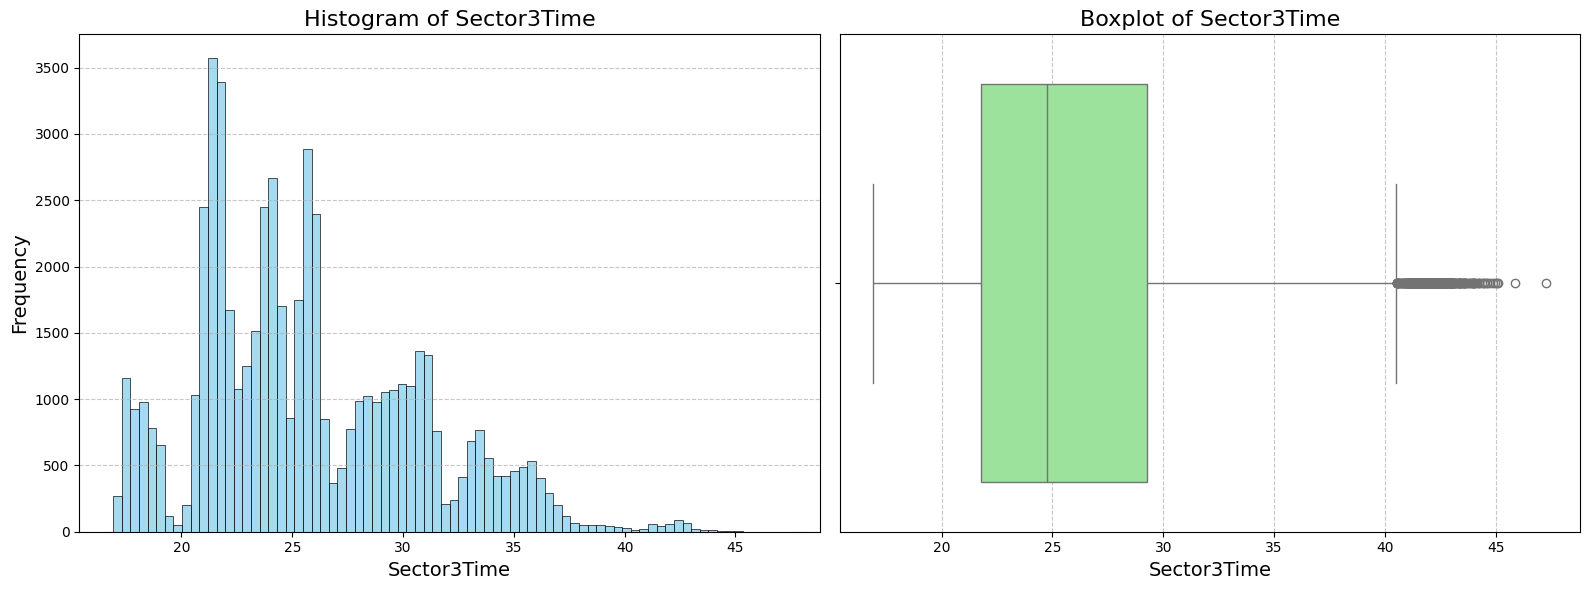

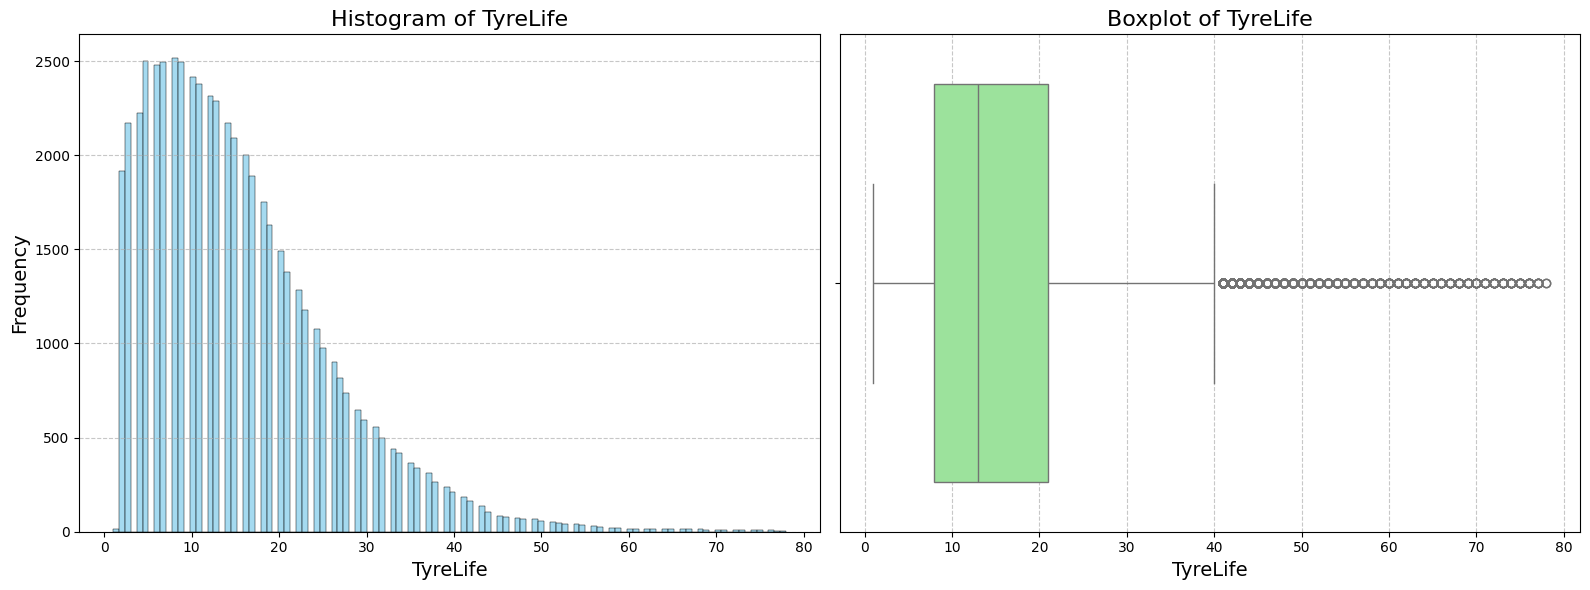

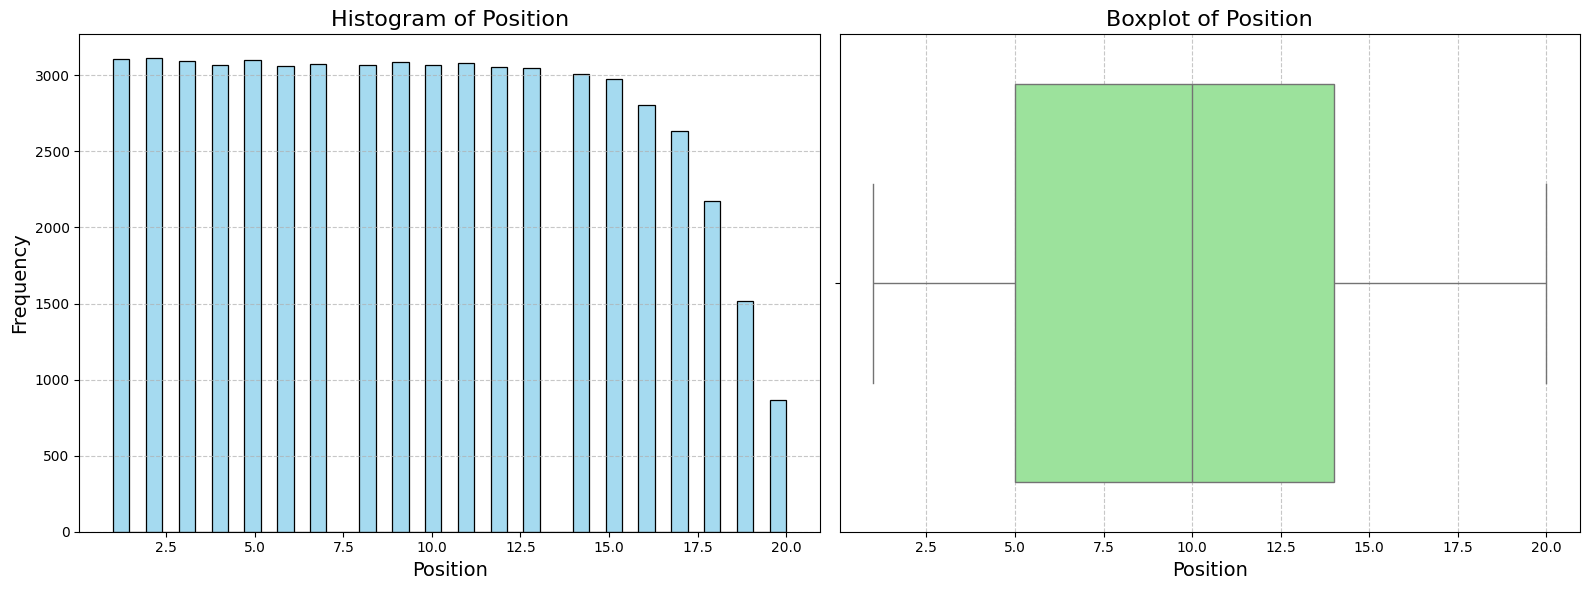

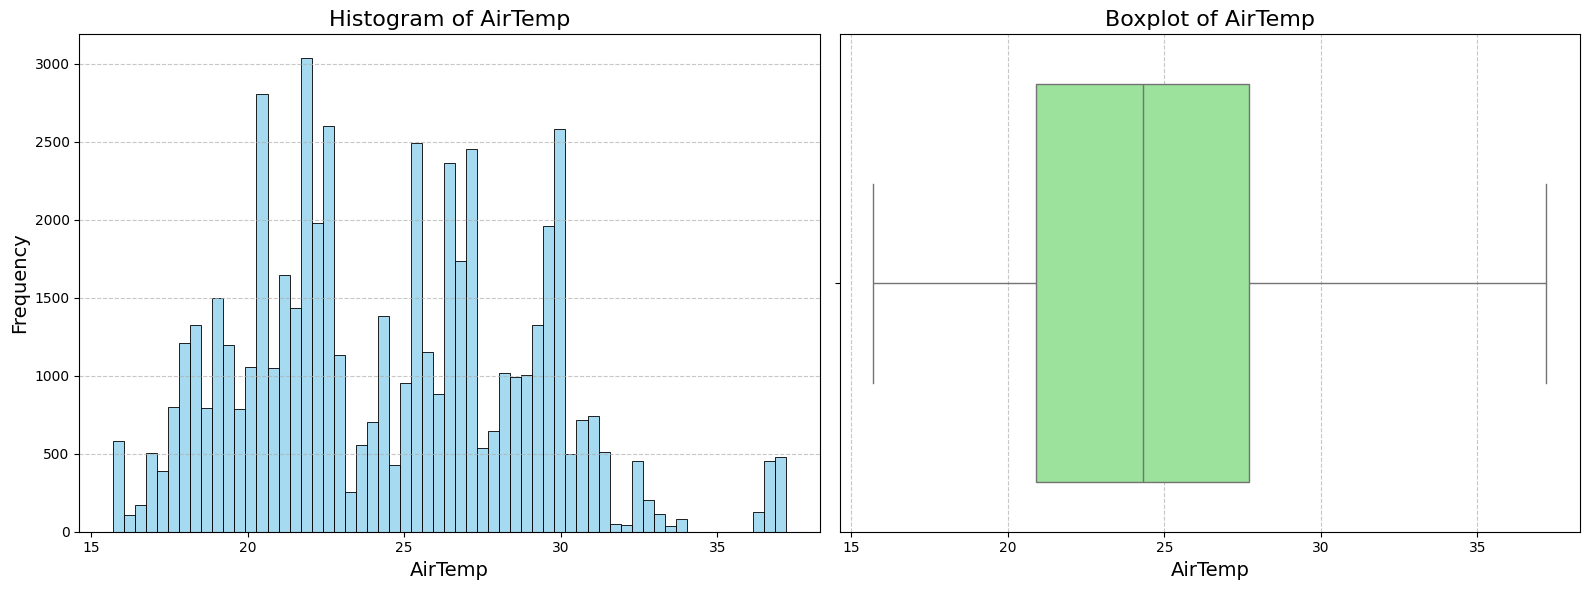

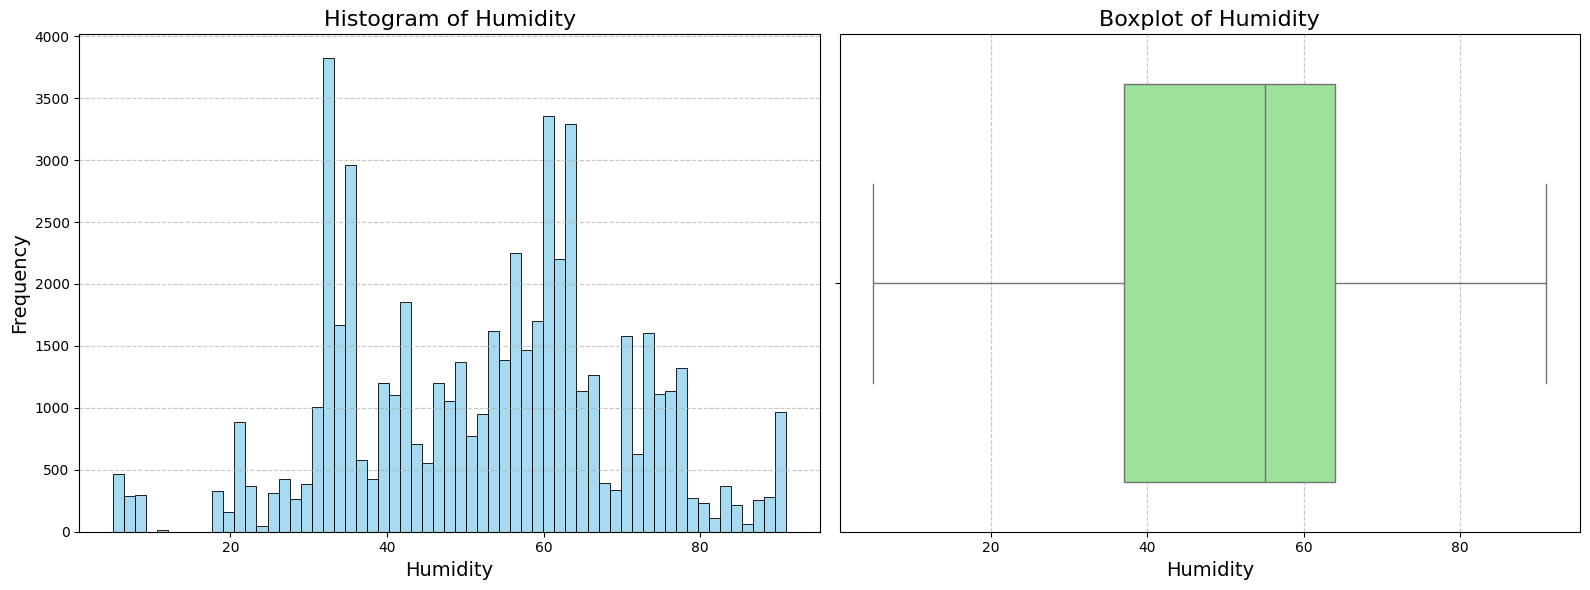

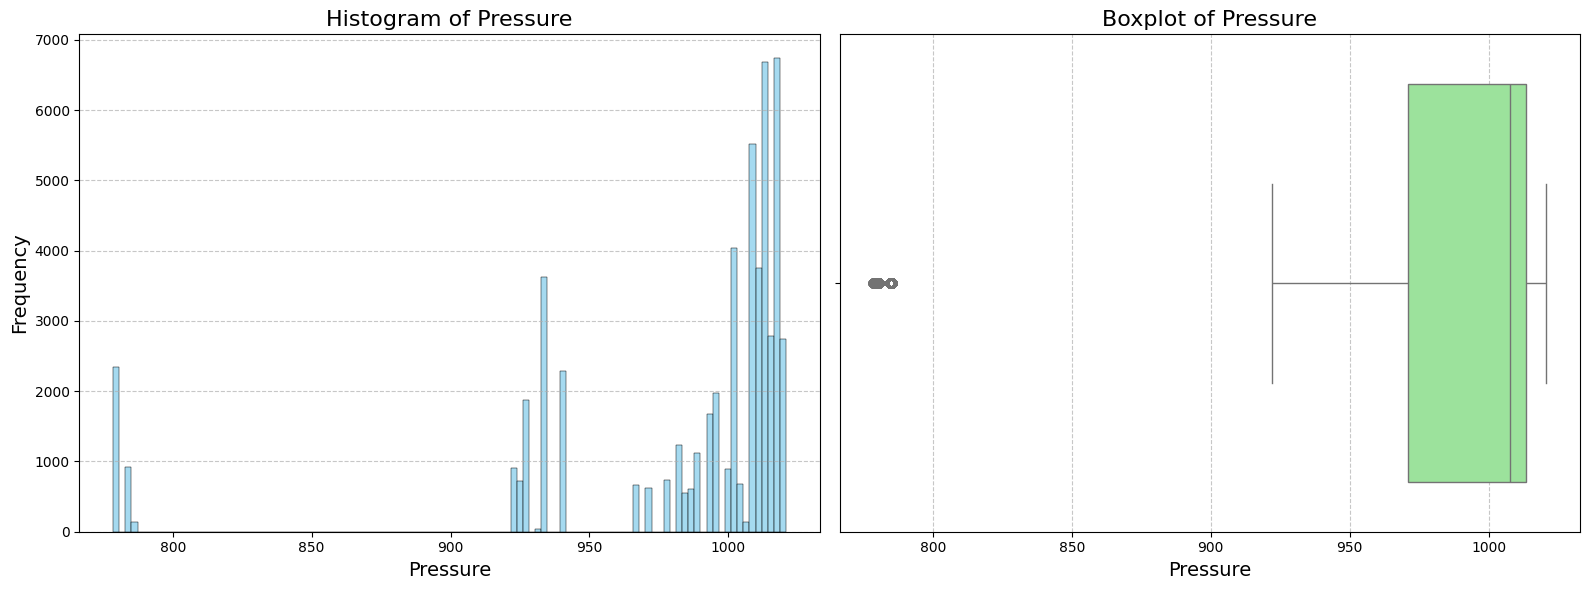

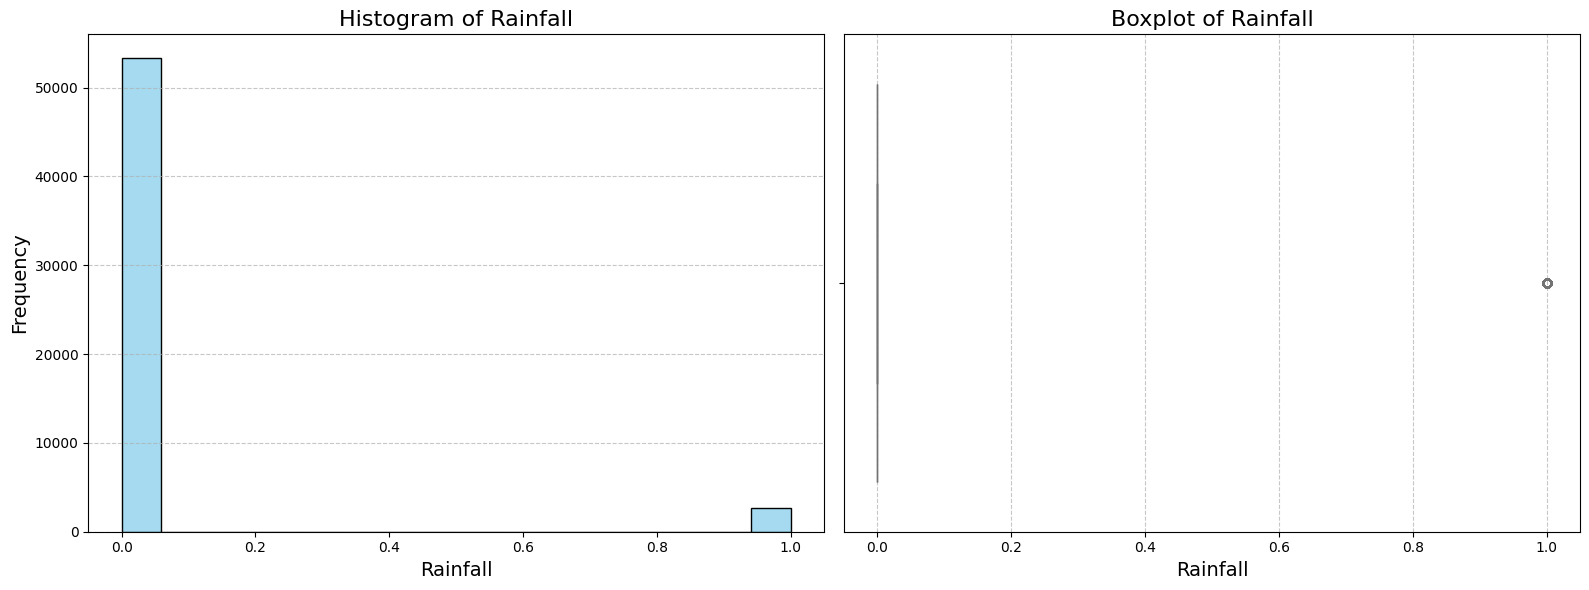

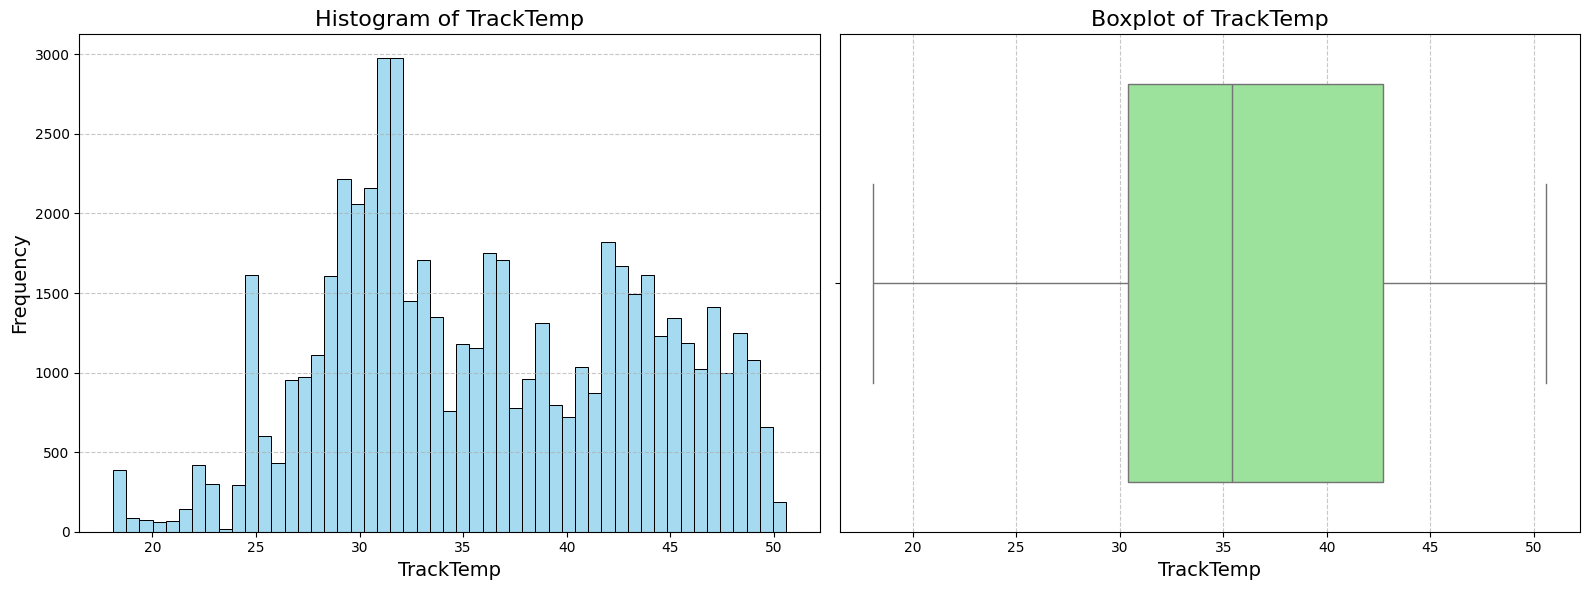

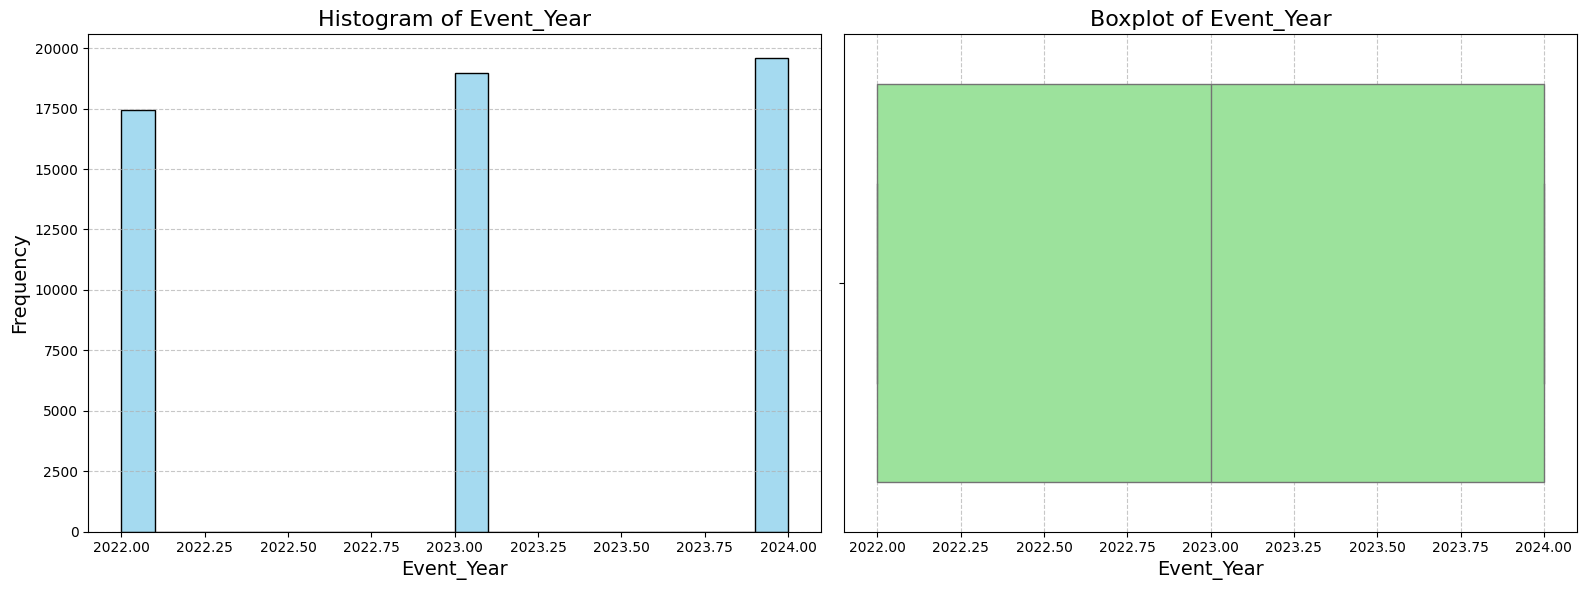

In [23]:
# for each of numerical features draw a histplot and boxplot graph using the function created above
for feature in numerical_columns:
    graph(feature)

## 3 Scale the features

In [24]:
all_races_df.describe()

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year
count,55954.000000,56007.000000,56007.000000,55996.000000,56003.000000,56005.000000,56007.000000,56007.000000,56007.000000,56007.000000,56007.000000,56007.000000,56007.000000,56007.000000
mean,87.302873,31.859857,2.153749,26.954615,34.691109,25.717588,15.581499,9.662364,24.420287,52.580963,980.045826,0.047708,36.132078,2023.038620
std,11.362672,18.466637,0.974655,6.280655,7.338811,5.012602,10.620254,5.378664,4.459855,17.652171,58.778731,0.213150,7.456126,0.812069
min,67.012000,2.000000,1.000000,16.835000,17.488000,16.913000,1.000000,1.000000,15.700000,5.000000,778.500000,0.000000,18.100000,2022.000000
25%,78.778250,16.000000,1.000000,21.414000,30.058000,21.778000,8.000000,5.000000,20.900000,37.000000,971.000000,0.000000,30.400000,2022.000000
50%,85.145000,31.000000,2.000000,28.428000,32.714000,24.734000,13.000000,10.000000,24.300000,55.000000,1007.700000,0.000000,35.400000,2023.000000
75%,94.029500,46.000000,3.000000,31.103000,39.366500,29.265000,21.000000,14.000000,27.700000,64.000000,1013.500000,0.000000,42.700000,2024.000000
max,149.321000,78.000000,8.000000,98.794000,84.968000,47.288000,78.000000,20.000000,37.200000,91.000000,1020.800000,1.000000,50.600000,2024.000000


In [25]:
# Remove Outliers from LapTime
# define a function to exclude outliers before scaling it properly
def exclude_outliers(df, feature):
    """
    Exclude outliers from a feature in a DataFrame using the IQR method.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the DataFrame to exclude outliers
    df_filtered = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df_filtered

In [26]:
# check datafram shape before removing outliers
all_races_df.shape

(56007, 17)

In [27]:
# remove outliers from LapTime column
all_races_df = exclude_outliers(all_races_df, 'LapTime')

# check daframe shape after outliers removed
all_races_df.shape 

(55497, 17)

In [28]:
# Preprocess LapNumber as Percentage of the race completed
# First, calculate the max lap number for each unique GrandPrix/Event_Year combination
all_races_df['LapPct'] = all_races_df['LapNumber'] / all_races_df.groupby(['Event_Year', 'GrandPrix'])['LapNumber'].transform('max')

# Display a sample
all_races_df[['Driver','LapNumber','LapPct','Event_Year','GrandPrix']].head()

,Driver,LapNumber,LapPct,Event_Year,GrandPrix
1,VER,2.0,0.035714,2022,Bahrain
2,VER,3.0,0.053571,2022,Bahrain
3,VER,4.0,0.071429,2022,Bahrain
4,VER,5.0,0.089286,2022,Bahrain
5,VER,6.0,0.107143,2022,Bahrain


In [29]:
# check missing values after dropping outliers
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Driver         0
LapTime        0
LapNumber      0
Stint          0
Sector1Time    1
Sector2Time    1
Sector3Time    0
Compound       0
TyreLife       0
Position       0
AirTemp        0
Humidity       0
Pressure       0
Rainfall       0
TrackTemp      0
Event_Year     0
GrandPrix      0
LapPct         0
dtype: int64


### 3.1 Building the Pipeline

In [30]:
# StandardScaler Pipeline for numerical features
num_transf_std = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler())
])

# MinMaxScaler Pipeline for numerical features
nun_transf_minmax = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmax_scaler', MinMaxScaler())
])

# RobustScaler Pipeline for numerical features
num_transf_robust = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

# RobustScaler & MinMaxSacler Pipeline. Combination of these two methods
num_transf_combined = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler())
])

# Categorical features Pipeline that will be encoded using OneHotEncoder 
cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [31]:
# Create a ColumnTransformer to apply OneHotEncoding and StandardScaler
numeric_preprocessor = ColumnTransformer(
    transformers=[
       #('num_std', num_transf_std, [numerical_columns]),              # StandardScale numerical features
        ('num_minmax', nun_transf_minmax, ['Position',
                                           'Stint',
                                           'TyreLife']),               # MinMaxScale numerical features
        ('num_robust', num_transf_robust, ['AirTemp',
                                           'TrackTemp',
                                           'Humidity',]),              # RobustScale numerical features
        ('num_combined', num_transf_combined, ['Pressure',
                                               'Sector1Time',
                                               'Sector2Time',
                                               'Sector3Time']),        # Combined two scalers 1° RobustScaler 2° MinMaxScaler
        ('cat', cat_transformer, ['Driver', 'GrandPrix', 'Compound']), # OneHotEncode categorical features
        ('passthrough_cols', 'passthrough', ['LapTime', 'LapPct'])     # passthrough means nothings will be done in these columns, it wil copy and paste to the output
    ],
    remainder='drop')                                                  # Columns in the original dataframe not mentioned in ColumnTransformer will be dropped

# Visualizing Pipelines
numeric_preprocessor

ColumnTransformer(transformers=[('num_minmax',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Position', 'Stint', 'TyreLife']),
                                ('num_robust',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['AirTemp', 'TrackTemp', 'Humidity']),
                                ('num_combined',
                                 Pipeline(step...mputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Pressure', 'Sector1Time', 'Sector2Time',
                                  'Sector3Time']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Driver', 'GrandPrix', 'Compound']),
                                ('passthrough_cols', 'passthrough',
                                 ['LapTime', 'LapPct'])])

### 3.2 Fit & Transform

In [32]:
# fit & transform dataframe
fitted_all_races = numeric_preprocessor.fit_transform(all_races_df)

# check dataframe fitted & transformed
fitted_all_races = pd.DataFrame(fitted_all_races, columns=numeric_preprocessor.get_feature_names_out())

In [33]:
fitted_all_races.dtypes

num_minmax__Position            float64
num_minmax__Stint               float64
num_minmax__TyreLife            float64
num_robust__AirTemp             float64
num_robust__TrackTemp           float64
num_robust__Humidity            float64
num_combined__Pressure          float64
num_combined__Sector1Time       float64
num_combined__Sector2Time       float64
num_combined__Sector3Time       float64
cat__Driver_ALB                 float64
cat__Driver_ALO                 float64
cat__Driver_BEA                 float64
cat__Driver_BOT                 float64
cat__Driver_COL                 float64
cat__Driver_DEV                 float64
cat__Driver_DOO                 float64
cat__Driver_GAS                 float64
cat__Driver_HAM                 float64
cat__Driver_HUL                 float64
cat__Driver_LAT                 float64
cat__Driver_LAW                 float64
cat__Driver_LEC                 float64
cat__Driver_MAG                 float64
cat__Driver_MSC                 float64


In [34]:
fitted_all_races.describe()

,num_minmax__Position,num_minmax__Stint,num_minmax__TyreLife,num_robust__AirTemp,num_robust__TrackTemp,num_robust__Humidity,num_combined__Pressure,num_combined__Sector1Time,num_combined__Sector2Time,num_combined__Sector3Time,cat__Driver_ALB,cat__Driver_ALO,cat__Driver_BEA,cat__Driver_BOT,cat__Driver_COL,cat__Driver_DEV,cat__Driver_DOO,cat__Driver_GAS,cat__Driver_HAM,cat__Driver_HUL,...,cat__GrandPrix_Canada,cat__GrandPrix_Great Britain,cat__GrandPrix_Hungary,cat__GrandPrix_Italy,cat__GrandPrix_Japan,cat__GrandPrix_Mexico,cat__GrandPrix_Miami,cat__GrandPrix_Monaco,cat__GrandPrix_Netherlands,cat__GrandPrix_Saudi Arabia,cat__GrandPrix_Singapore,cat__GrandPrix_Spain,cat__GrandPrix_USA,cat__Compound_HARD,cat__Compound_INTERMEDIATE,cat__Compound_MEDIUM,cat__Compound_SOFT,cat__Compound_WET,passthrough_cols__LapTime,passthrough_cols__LapPct
count,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,...,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000,55497.000000
mean,0.455880,0.165785,0.189836,0.016330,0.056305,-0.097948,0.831125,0.241221,0.442921,0.286079,0.044291,0.051913,0.003406,0.050760,0.004991,0.009370,0.000883,0.050922,0.052507,0.035191,...,0.053931,0.048507,0.063193,0.046039,0.032524,0.061192,0.050760,0.058868,0.061211,0.040074,0.039624,0.062580,0.047354,0.469467,0.056454,0.351442,0.121322,0.001315,87.013405,0.513331
std,0.283144,0.139190,0.138053,0.637931,0.605370,0.647967,0.243040,0.146112,0.186557,0.159318,0.205742,0.221853,0.058258,0.219508,0.070473,0.096344,0.029701,0.219840,0.223050,0.184264,...,0.225883,0.214837,0.243311,0.209570,0.177389,0.239685,0.219508,0.235380,0.239718,0.196135,0.195075,0.242208,0.212397,0.499071,0.230797,0.477425,0.326504,0.036245,10.941921,0.282975
min,0.000000,0.000000,0.000000,-1.228571,-1.414634,-1.851852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.012000,0.025641
25%,0.210526,0.000000,0.090909,-0.485714,-0.406504,-0.666667,0.794470,0.109380,0.325635,0.159737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.728000,0.267606
50%,0.473684,0.142857,0.155844,0.000000,0.000000,0.000000,0.945935,0.277748,0.393609,0.255309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.070000,0.508772
75%,0.684211,0.285714,0.259740,0.514286,0.593496,0.333333,0.969872,0.341383,0.563926,0.402403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,93.832000,0.760563
max,1.000000,1.000000,1.000000,1.842857,1.227642,1.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,116.900000,1.000000


### 3.3 Train & Test Split

In [52]:
import joblib

joblib.dump(numeric_preprocessor, 'preprocessador.pkl')

['preprocessador.pkl']

In [35]:
X = fitted_all_races.drop(columns = ['passthrough_cols__LapTime',
                                     'num_combined__Sector1Time',
                                     'num_combined__Sector2Time',
                                     'num_combined__Sector3Time'])

In [36]:
y = fitted_all_races['passthrough_cols__LapTime']

In [37]:
y

0        97.880
1        98.357
2        98.566
3        98.877
4        98.940
          ...  
55492    88.168
55493    87.731
55494    87.781
55495    87.816
55496    88.010
Name: passthrough_cols__LapTime, Length: 55497, dtype: float64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42  # TEST = 30%
)

In [39]:
model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3
)

In [40]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [41]:
result = model.score(X_test, y_test)
result

0.9698705098697766

In [42]:
# Robust Evaluation with Cross-Validation
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

In [43]:
print(f"\nCross-validation R² Scores: {cv_scores}")
print(f"Average R²: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Final Training and Test Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Cross-validation R² Scores: [0.96884051 0.96940969 0.96817437 0.97101337 0.96631027]
Average R²: 0.9687 (±0.0015)



Model evaluation Gradient Boosting:
R²: 0.9699
MAE: 1.3412
MSE: 3.6320
RMSE: 1.9058
MAPE: 1.5500


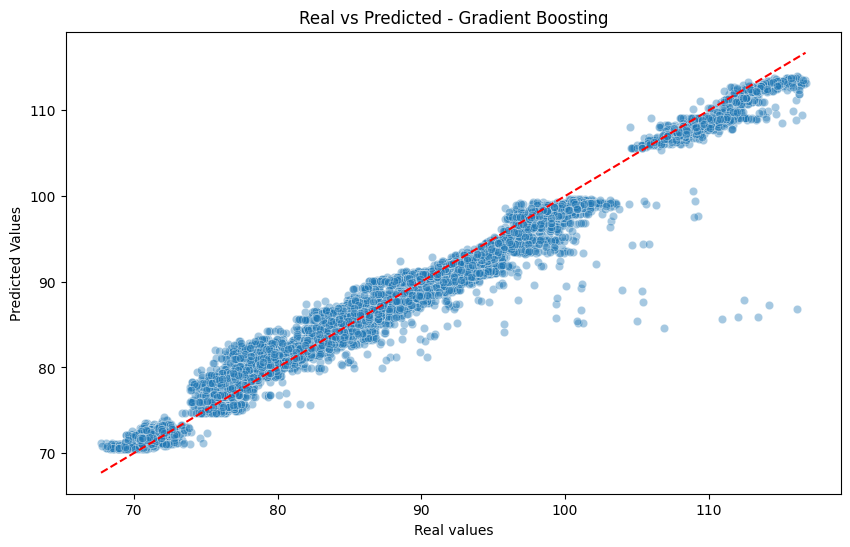

In [44]:
# Comprehensive metrics
def evaluate_model(y_true, y_pred, model_name=""):
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    print(f"\nModel evaluation {model_name}:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Plot of actual vs. predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel('Real values')
    plt.ylabel('Predicted Values')
    plt.title(f'Real vs Predicted - {model_name}')
    plt.show()
    
    return metrics

# Avaliar o modelo
metrics = evaluate_model(y_test, y_pred, "Gradient Boosting")

In [45]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge": Ridge(),
#     "Lasso": Lasso(),
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42),
#     "XGBoost": XGBRegressor(random_state=42),
#     "LightGBM": LGBMRegressor(random_state=42),
#     "SVR": SVR(),
#     "KNN": KNeighborsRegressor()
# }

In [46]:
# def compare_models(X_train, y_train, X_test, y_test, models):
#     results = {}
    
#     for name, model in models.items():
#         # Treino e validação cruzada
#         cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', verbose=0)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
        
#         # Métricas
#         metrics = {
#             'CV R² Mean': np.mean(cv_scores),
#             'CV R² Std': np.std(cv_scores),
#             'Test R²': r2_score(y_test, y_pred),
#             'MAE': mean_absolute_error(y_test, y_pred),
#             'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
#             'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
#         }
        
#         results[name] = metrics
        
#         print(f"\n{name}")
#         print(f"CV R²: {metrics['CV R² Mean']:.4f} (±{metrics['CV R² Std']:.4f})")
#         print(f"Test R²: {metrics['Test R²']:.4f}")
#         print(f"MAE: {metrics['MAE']:.4f}")
    
#     return pd.DataFrame(results).T.sort_values(by='Test R²', ascending=False)

In [48]:
# results_df = compare_models(X_train, y_train, X_test, y_test, models)

# # Gráfico de comparação
# plt.figure(figsize=(12, 6))
# results_df['Test R²'].sort_values().plot(kind='barh')
# plt.title('Comparação de Modelos por R² no Teste')
# plt.xlabel('R² Score')
# plt.show()

In [49]:
new = X.iloc[[0]].copy()
new

,num_minmax__Position,num_minmax__Stint,num_minmax__TyreLife,num_robust__AirTemp,num_robust__TrackTemp,num_robust__Humidity,num_combined__Pressure,cat__Driver_ALB,cat__Driver_ALO,cat__Driver_BEA,cat__Driver_BOT,cat__Driver_COL,cat__Driver_DEV,cat__Driver_DOO,cat__Driver_GAS,cat__Driver_HAM,cat__Driver_HUL,cat__Driver_LAT,cat__Driver_LAW,cat__Driver_LEC,...,cat__GrandPrix_Brazil,cat__GrandPrix_Canada,cat__GrandPrix_Great Britain,cat__GrandPrix_Hungary,cat__GrandPrix_Italy,cat__GrandPrix_Japan,cat__GrandPrix_Mexico,cat__GrandPrix_Miami,cat__GrandPrix_Monaco,cat__GrandPrix_Netherlands,cat__GrandPrix_Saudi Arabia,cat__GrandPrix_Singapore,cat__GrandPrix_Spain,cat__GrandPrix_USA,cat__Compound_HARD,cat__Compound_INTERMEDIATE,cat__Compound_MEDIUM,cat__Compound_SOFT,cat__Compound_WET,passthrough_cols__LapPct
0,0.052632,0.0,0.051948,-0.071429,-0.528455,-1.074074,0.957078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.035714


In [50]:
rf = RandomForestRegressor().fit(X_train, y_train)

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
prediction = rf.predict(new)
prediction

In [ ]:
## Conectar o modelo com a pipeline e fazer o deploy dele API.
## Simular a corrida com um piloto do começo até o final e avaliar o resultado (objetivo é ter uma ideia de como está o modelo)

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# Exemplo simples de modelo
modelo = rf

# Salvando o modelo treinado em disco
joblib.dump(modelo, 'random_forest_modelo.pkl')

In [ ]:
# Carregando o modelo salvo posteriormente
modelo_carregado = joblib.load('random_forest_modelo.pkl')

# Fazendo previsões com o modelo carregado
y_pred = modelo_carregado.predict(X_test)

In [ ]:
y_pred